In [ ]:
AR 모형으로 삼성전자 주가 예측

In [ ]:
# pykrx	한국 주식시장(KRX)의 삼성전자 일별 데이터를 가져옵니다.
# AutoReg	자기회귀(AR) 모형으로 과거 종가 데이터를 기반으로 미래 값을 예측합니다.
# lags=5	이전 5일 데이터를 기준으로 예측 (조정 가능)
# RMSE	예측 성능 평가용 지표 (낮을수록 좋음)

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


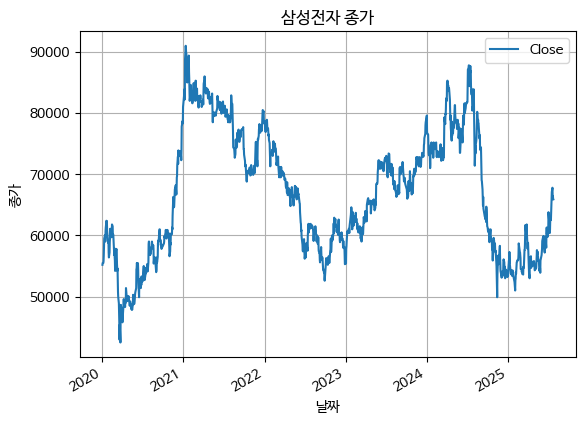

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with

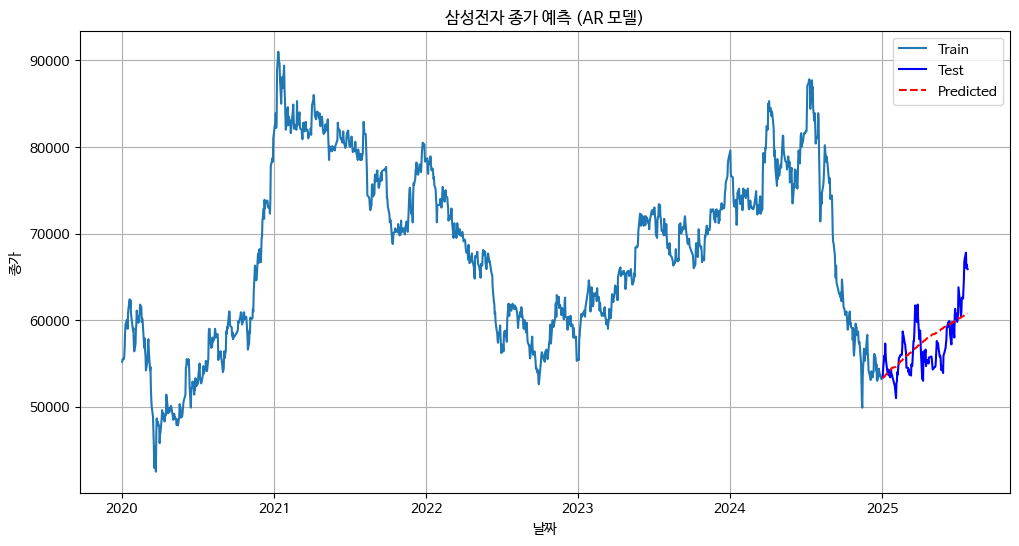

📌 RMSE: 2638.10


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from statsmodels.tsa.ar_model import AutoReg
import datetime

# 1. 📥 삼성전자 주가 데이터 가져오기 (2020년 이후)
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.today()

df = stock.get_market_ohlcv_by_date(start.strftime('%Y%m%d'), end.strftime('%Y%m%d'), "005930")  # 삼성전자
df = df[['종가']].rename(columns={'종가': 'Close'})

# 2. 📈 종가 시계열 시각화
df.plot(title='삼성전자 종가')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.grid(True)
plt.show()

# 3. 🧠 AR 모형 학습
# 데이터 분할 (학습용 90%, 테스트용 10%)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# AR 모델 적합
model = AutoReg(train['Close'], lags=5, old_names=False)
model_fit = model.fit()

# 4. 🔮 예측
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
test['Predicted'] = predictions.values

# 5. 📉 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test', color='blue')
plt.plot(test.index, test['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title('삼성전자 종가 예측 (AR 모델)')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.grid(True)
plt.show()

# 6. 📐 간단한 평가 지표
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test['Close'], test['Predicted'], squared=False)
print(f"📌 RMSE: {rmse:.2f}")


In [ ]:
삼성전자 일별 종가 데이터를 주간/월간 단위로 리샘플링

In [ ]:
# resample(rule='W')	'W': 주간, 'M': 월간 종가 기준
# AutoReg	AR(lags=4) 모델을 적용하여 미래 예측
# get_prediction()	예측값과 신뢰구간(confidence interval) 함께 출력
# fill_between()	예측 구간을 그림자 영역으로 시각화
# RMSE	실제값 vs 예측값 비교를 위한 지표

C:\Users\JYB\AppData\Local\Temp\ipykernel_4400\3171933248.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return data['Close'].resample(rule).last()


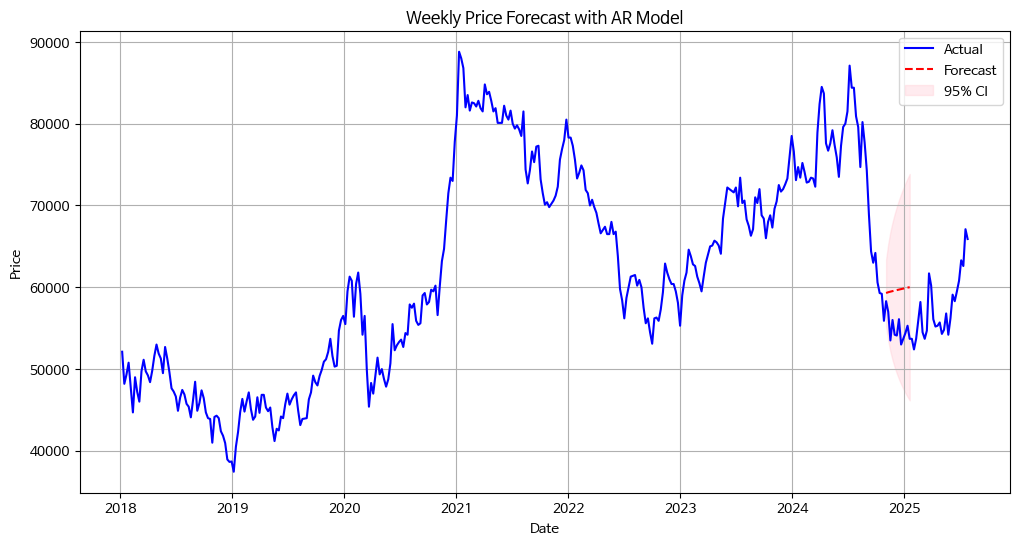

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Weekly RMSE: 4841.33


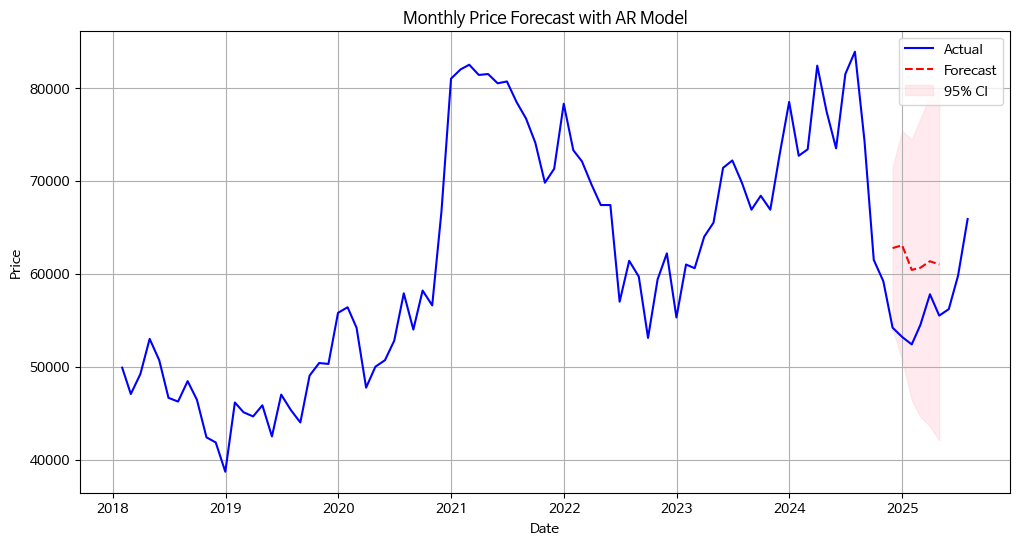

Monthly RMSE: 6694.67


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from statsmodels.tsa.ar_model import AutoReg
import datetime
from sklearn.metrics import mean_squared_error

# 📥 1. 삼성전자 주가 데이터 수집
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime.today()

df = stock.get_market_ohlcv_by_date(start.strftime('%Y%m%d'), end.strftime('%Y%m%d'), "005930")
df = df[['종가']].rename(columns={'종가': 'Close'})

# 📆 2. 주간/월간 리샘플링 함수
def resample_price(data, rule='W'):
    return data['Close'].resample(rule).last()

df.index = pd.to_datetime(df.index)
weekly_data = resample_price(df, 'W')   # 'W' → 주간
monthly_data = resample_price(df, 'M')  # 'M' → 월간

# 🔁 3. 예측 함수 정의
def forecast_AR_model(ts, lags=4, forecast_steps=10, label='Weekly'):
    train_size = int(len(ts) * 0.9)
    train, test = ts[:train_size], ts[train_size:]

    model = AutoReg(train, lags=lags, old_names=False)
    model_fit = model.fit()

    # 예측값 및 예측 구간 계산
    pred = model_fit.get_prediction(start=train_size, end=train_size + forecast_steps - 1, dynamic=False)
    pred_mean = pred.predicted_mean
    ci = pred.conf_int(alpha=0.05)  # 95% 신뢰구간

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(ts.index, ts, label='Actual', color='blue')
    future_index = pd.date_range(ts.index[train_size], periods=forecast_steps + 1, freq=ts.index.freq or 'W')[1:]
    plt.plot(future_index, pred_mean, label='Forecast', color='red', linestyle='--')
    plt.fill_between(future_index, ci.iloc[:, 0], ci.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')
    plt.title(f'{label} Price Forecast with AR Model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    rmse = mean_squared_error(ts[train_size:train_size + forecast_steps], pred_mean, squared=False)
    print(f"{label} RMSE: {rmse:.2f}")

# 📈 4. 예측 실행
forecast_AR_model(weekly_data, lags=4, forecast_steps=12, label='Weekly')    # 12주 예측
forecast_AR_model(monthly_data, lags=4, forecast_steps=6, label='Monthly')   # 6개월 예측


In [ ]:
# 예측 결과 예시 (그래프 형태)
# 파란 선: 실제 데이터
# 빨간 점선: 예측 값
# 분홍 그림자: 95% 예측 신뢰 구간